# Part 1/N - Tracking larval zebrafish

This is a polished notebook.

There is more information inside compared to the raw version, as generated yesterday. Be careful, some operations may **flood your memory**! Don't just run all cells, please go step by step and check if it is good to execute the cell!

This notebook shows you how to

1. Load a video
2. Thresholding
3. Center of mass determination by image moments
4. Multiple instance tracking by blob detection
5. Multiple instance tracking by connected components (NEW!)


In [3]:
# Load relevant libraries

import numpy as np # maths
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import imageio as io # loading and writing images and movies
from ipywidgets import interact # interactive widgets, e.g. for finding threshold

## 1. Load a video

In [4]:
ims = io.mimread("zebrafish.mp4", memtest=False)

```io.mimread``` returns a ```list``` of ```Arrays```.
It is better to use a multidimensional array, thus, we convert it to a ```np.ndarray```:

In [5]:
ims = np.asarray(ims)

Now, we can look at the data shape, should be ```Time x Height x Width x Channels```

In [6]:
ims.shape

(2500, 488, 648, 3)

Okay, we have three channels, but isn't the video grayscale?

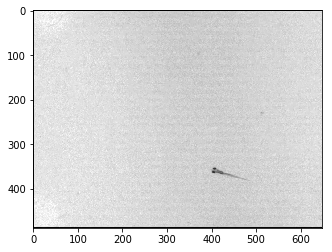

In [7]:
# Show first frame
plt.imshow(ims[0])

Yes, so how can we get rid of these extra channels?

## Way 1: Take 1 channel

In [17]:
# Check if channels are the same
(ims[..., 0] == ims[..., 1]).all(), \
    (ims[..., 1] == ims[..., 2]).all(), \
    (ims[..., 0] == ims[..., 2]).all()

(True, True, True)

Okay, all channels are the same (as expected), we can just use one:

In [34]:
way1 = ims[..., 0]

## Way 2: Mean

In [23]:
way2 = ims.mean(3)

Be careful, we are doing a division, and this blows up your memory! Previously, your dtype was ```uint8```, now it is...

In [25]:
way2.dtype

dtype('float64')

8 times more data! For nothing! -> Don't do it. It is also *wrong*. If you would like to convert RGB data (just imagine you have real RGB data, like a photograph) to grayscale, to get the **luminance** information you have to do it the following way:

## Way 3: Luminance extraction

Red, green and blue are not excited the same way in our retina, we have a preference for green, then a little bit red, and almost no blue.

We're therefore doing a **weighted average**:

$$Y = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B, $$

were $Y$ is the luminance channel, $R$, $G$, and $B$ the individual color channel.

The scikit-image function ```rgb2gray``` is exactly doing this:

In [9]:
from skimage.color import rgb2gray

In [10]:
converted = rgb2gray(ims)

In [11]:
converted.dtype

dtype('float64')

Again, be careful, this is again ```float64```, it was using my 32 GB of memory!! --> convert it to something else to avoid memory explosion. You can also do this in loop to save memory space.

Favorite solution: take 1 channel

In [35]:
ims = ims[..., 0]

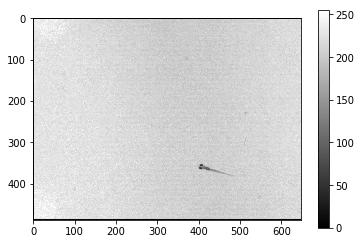

In [19]:
# Show the first frame
plt.imshow(ims[0], cmap='gray')
plt.colorbar()

# 2. Thresholding

If you would like to dividie the image into two categories (foreground and background), you can use thresholding:

In [36]:
im = ims[0]

The background is bright, so close to 255, the foreground (the fish) is close to 0. So if you use

    im < t
    
You are looking for px that are **darker** than a given threshold (selecting in our case foreground), and if you would do

    im > t
    
you are looking for px that are **brighter** than a given threshold (selecting in our case the background). Try it out:

In [40]:
@interact
def threshold(t:(0, 255)):
    # Select foreground,
    # conversion to uint8 is a hack to display colorbar
    plt.imshow((im>t).astype(np.uint8))
    
    # Select background
    # plt.imshow((im<t).astype(np.uint8))
    
    plt.colorbar()

interactive(children=(IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interact',))

Let's check if the threshold is good for more than a single frame:

In [41]:
@interact
def thresholdOverMovie(frame:(0, ims.shape[0]-1), t:(0, 255)):
    plt.imshow((ims[frame] < t).astype(np.uint8))
    plt.colorbar()

interactive(children=(IntSlider(value=1249, description='frame', max=2499), IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interact',))

It seems to be a threshold ```t``` close to **82** does a fair job.

# 3. Center of mass determination by image moments

[Image moments](https://en.wikipedia.org/wiki/Image_moment) are good to calculate some properties from images, e.g. the center of mass, or shape orientation, etc. That's the definition:

$$ M_{p,q} = \sum_x\sum_y x^p \cdot y^q \cdot I(x,y) $$

In [42]:
# Nicely inbuilt in scikit-image:
from skimage.measure import moments

We try it on a single frame and a given threshold

In [50]:
im = ims[0]
t = 82 # threshold

In [51]:
# Returns by default up to the third moments M[0,0] ... M[3, 3]
M = moments(im < 82)
print(M)

[[3.60100000e+03 8.55664000e+05 3.68735094e+08 1.78531305e+11]
 [8.81600000e+05 2.10288005e+08 9.05733108e+10 4.37921374e+13]
 [3.88332474e+08 1.01423586e+11 4.37107474e+13 2.11578124e+16]
 [1.78914988e+11 4.90644904e+13 2.11541099e+16 1.02480740e+19]]


In [52]:
# M[0, 0] is giving you the area
M[0, 0]

3601.0

3601 px for the fish?! Something has to be wrong!

(-0.5, 647.5, 487.5, -0.5)

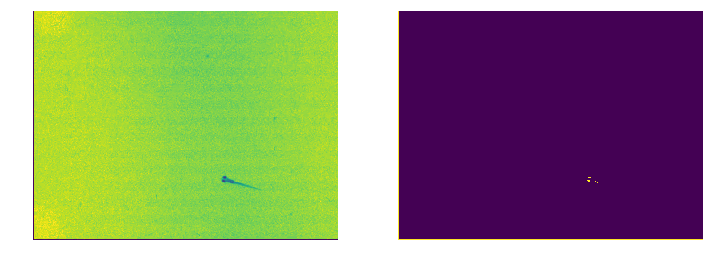

In [56]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(im)
plt.axis('off')

plt.subplot(122)
plt.imshow(im < t)
plt.axis('off')

Do you see the black rim? This is an artifact from the camera! We have to remove this, otherwise it is confounding are tracking algorithm.

In [57]:
# Cropping the image by 4 px on each side
ims = ims[:, 4:-4, 4:-4]

In [58]:
ims.shape

(2500, 480, 640)

Now we try it again

In [60]:
im = ims[0]
t = 82

In [61]:
M = moments(im < t)
M[0, 0]

41.0

That looks more reasonable!

Now we can calculate the center of mass by using the area ```M[0, 0]``` and the first moment for ```x``` and ```y```. Ensure that you don't mixup the dimensions!

In [62]:
y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]

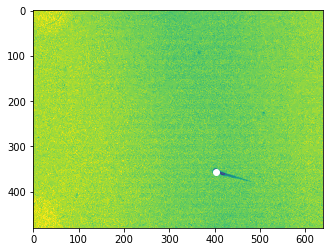

In [64]:
plt.imshow(im)
plt.scatter(x, y, c='w')

**Beautiful!**

Now we can do it for the whole movie!

In [65]:
# Progress bar
from tqdm.notebook import tqdm

In [124]:
# Define a threshold
threshold = 82
# Prepare an empty list for the positions
# positions = []
# or use a predefined numpy array:
positions = np.empty((ims.shape[0], 2))

# Iterate over frames
for frame in tqdm(range(ims.shape[0])):
    # calculate the positions
    # 1) get image
    im = ims[frame]
    # 2) threshold
    thresholded_im = im < threshold
    # 3) compute position
    M = moments(thresholded_im)
    y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]
    # 4) append image position
    # positions.append((x, y)) # if using a list
    positions[frame] = x, y # if using a predefined numpy array

HBox(children=(FloatProgress(value=0.0, max=2500.0), HTML(value='')))

Let's see how good we are

In [72]:
@interact
def showFrameAndTrace(up_to_frame:(0, ims.shape[0]-1)=0):
    plt.subplot(121)
    plt.imshow(ims[up_to_frame])
    
    plt.subplot(122)
    plt.imshow(np.zeros_like(ims[up_to_frame]))
    # I am plotting all positions up to the selected frame
    # with * I am unpacking the array, and with .T I am transposing it,
    # such that I can extract corresponding x and y pairs for plotting
    plt.plot(*positions[:up_to_frame].T)
    

interactive(children=(IntSlider(value=0, description='up_to_frame', max=2499), Output()), _dom_classes=('widget-interact',))

Okay, when tracking more than **1** fish, this doesn't work anymore! Check frames > 1605!

What can we do else?

# 4. Multiple instance tracking by blob detection

Checkout the [scikit-image blob detection introduction](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html) for more information! Basically, you can use different operations to find the blobs.

In [74]:
from skimage.feature import blob_dog, blob_log, blob_doh

In [75]:
# Testing on a frame that has more than 1 fish, using our threshold
# It doesn't work, if we don't adjust the threshold in the function
individual_fish = blob_dog(ims[1905] < threshold, threshold=.25)

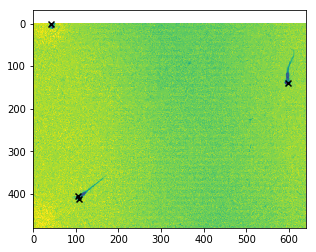

In [81]:
plt.imshow(ims[1905])
for fish in individual_fish:
    plt.scatter(fish[1], fish[0], alpha=1, marker='x', c='k')

It found all fish, but also the one on the bottom left twice, so one would have to adjust the threshold or do more post-processing. Additionally, it is pretty slow:

In [82]:
%timeit blob_dog(ims[1905] < threshold, threshold=.25)

628 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 5. Multiple instance tracking by connected components (NEW!)

Something we haven't talked about yesterday, but something I would like to show you, because this is how we implemented multiple fish tracking in [Stytra](https://github.com/portugueslab/stytra)!

In [83]:
# Use OpenCV, a great Computer Vision library! Some things are better,
# and some are worse than scikit-image
import cv2

We use ```cv2.connectedComponentsWithStats```. One has to adjust the threshold to avoid finding to many blobs, and OpenCV needs some specific way to access images (views or copies), otherwise it complains

In [111]:
threshold_opencv = 60

In [105]:
# We use the same multiple fish frame
%timeit cv2.connectedComponentsWithStats((ims[1905] < threshold_opencv).view(np.uint8))

1.6 ms ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That is way faster! On my computer ca. 1.5 ms (OpenCV) vs. 628 ms (Scikit-Image)! It is therefore >400 times faster and you can do it realtime (in theory, up to ~650 Hz).

In [112]:
_, _, centroids, _ = cv2.connectedComponentsWithStats((ims[1905] < threshold_opencv).view(np.uint8))
# The centroids are the bounding boxes of the blobs,
# the first centroid is most of the time the area
centroids = centroids[1:]

In [113]:
centroids

array([[ 39,   4,   3,   5,   9],
       [ 45,   7,   4,   4,   8],
       [591, 138,   3,   4,   8],
       [599, 138,   3,   5,  10],
       [102, 405,   3,   4,   9],
       [106, 411,   5,   4,  12]], dtype=int32)

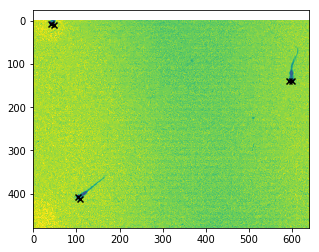

In [115]:
plt.imshow(ims[1905])
for c in centroids:
    plt.scatter(*(c[:2]+c[2:4]//2), marker='x', c='k')

With data pre- and post-processing we can merge individual points to get individual fish. Just checkout the Stytra code, and morphological operations (dilation!)

# Extra: How to make a nice GIF for twitter

In [141]:
@interact
def showFancyFrame(ix:(0,300)):
    frame = ims[ix]
    fig = plt.figure(figsize=(6,2))
    plt.imshow(frame, cmap='gray')
    
    
    
    for alpha, i in enumerate(range(ix, ix-30, -3)):
        if i >= 0:
            x, y = positions[i]
            a = (10-alpha)/20 if alpha else 1
            plt.scatter(x, y, marker='x', c='r', alpha=a)
            
    plt.xlim([300, 540])
    plt.ylim([400, 300])
    plt.axis('off')

interactive(children=(IntSlider(value=150, description='ix', max=300), Output()), _dom_classes=('widget-interact',))

In [152]:
movie = []

for ix, frame in tqdm(enumerate(ims[:200]), total=200):
    fig = plt.figure(figsize=(6,2))
    plt.imshow(frame, cmap='gray')
    
    for alpha, i in enumerate(range(ix, ix-30, -3)):
        if i >= 0:
            x, y = positions[i]
            a = (10-alpha)/20 if alpha else 1
            plt.scatter(x, y, marker='x', c='r', alpha=a)
            
    plt.xlim([300, 540])
    plt.ylim([400, 300])
    plt.axis('off')
    plt.close()
    
    fig.canvas.draw() 
    rgb = fig.canvas.tostring_rgb()
    shape = fig.canvas.get_width_height()[::-1] + (3,)
    im = np.frombuffer(rgb, dtype=np.uint8).reshape(shape)
    
    movie.append(im)

HBox(children=(FloatProgress(value=0.0, max=200.0), HTML(value='')))

In [144]:
!pip install pygifsicle
from pygifsicle import optimize # makes GIF smaller

  Created wheel for pygifsicle: filename=pygifsicle-1.0.1-py3-none-any.whl size=6438 sha256=17e3466f6fa290d66b34f3e98ddd60a6636c6f3107ab29cc5a0450e405af0873
  Stored in directory: c:\users\me\appdata\local\pip\cache\wheels\a3\99\81\43c3aa150f1a98c579be600fe53dea3d16ec5b8fe82d28c8df
Successfully built pygifsicle


You should consider upgrading via the 'c:\users\me\anaconda3\python.exe -m pip install --upgrade pip' command.


In [146]:
io.mimwrite("tracking_fish_result.gif", movie[40:200], fps=20)

In [151]:
optimize(r"tracking_fish_result.gif")